<a href="https://colab.research.google.com/github/timkatima/AnaliticPZ3/blob/master/carsSales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# ЯЧЕЙКА 1 — Установка и запуск Spark
!pip install pyspark -q

from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Lab5").getOrCreate()

In [26]:
# ЯЧЕЙКА 2 — ФИНАЛЬНАЯ ВЕРСИЯ ДЛЯ ТВОЕГО ФАЙЛА datasetNew.xlsx (РАБОТАЕТ ВСЕГДА)

from google.colab import files
import pandas as pd

print("Загрузи свой datasetNew.xlsx (последний раз — обещаю, работает!)")
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# ЧИТАЕМ ВСЁ КАК ТЕКСТ, ЧТОБЫ НИЧЕГО НЕ ПРЕВРАЩАЛОСЬ В ДАТЫ
print("Читаем ВЕСЬ файл как текст...")
pandas_df = pd.read_excel(filename, dtype=str)   # ← ВОТ ЭТО ГЛАВНОЕ!

# Теперь вручную превращаем нужные колонки в числа
print("Преобразуем нужные колонки в числа...")
cols_to_float = ["year", "odometer", "mmr", "sellingprice"]
for col in cols_to_float:
    pandas_df[col] = pd.to_numeric(pandas_df[col], errors='coerce')  # нечисла → NaN

# Оставляем только нужные столбцы
pandas_df = pandas_df[["year", "make", "model", "odometer", "mmr", "sellingprice"]]

# Заменяем NaN на None (для Spark)
pandas_df = pandas_df.where(pd.notnull(pandas_df), None)

print(f"Готово! Загружено {len(pandas_df):,} строк")

# КОНВЕРТИРУЕМ В SPARK — ТЕПЕРЬ 100% БЕЗ ОШИБОК
df = spark.createDataFrame(pandas_df)

print("УСПЕШНО! ТВОЙ ФАЙЛ В SPARK!")
print("Строк:", df.count())
df.printSchema()
df.show(10, truncate=False)

Загрузи свой datasetNew.xlsx (последний раз — обещаю, работает!)


Saving datasetNew.xlsx to datasetNew (10).xlsx
Читаем ВЕСЬ файл как текст...
Преобразуем нужные колонки в числа...
Готово! Загружено 558,837 строк
УСПЕШНО! ТВОЙ ФАЙЛ В SPARK!
Строк: 558837
root
 |-- year: long (nullable = true)
 |-- make: string (nullable = true)
 |-- model: string (nullable = true)
 |-- odometer: double (nullable = true)
 |-- mmr: double (nullable = true)
 |-- sellingprice: double (nullable = true)

+----+---------+-------------------+--------+-------+------------+
|year|make     |model              |odometer|mmr    |sellingprice|
+----+---------+-------------------+--------+-------+------------+
|2015|Kia      |Sorento            |16639.0 |20500.0|21500.0     |
|2015|Kia      |Sorento            |9393.0  |20800.0|21500.0     |
|2014|BMW      |3 Series           |1331.0  |31900.0|30000.0     |
|2015|Volvo    |S60                |14282.0 |27500.0|27750.0     |
|2014|BMW      |6 Series Gran Coupe|2641.0  |66000.0|67000.0     |
|2015|Nissan   |Altima             |5554.0 

In [27]:
# ЯЧЕЙКА 3 — Предобработка
from pyspark.sql.functions import col, when

df = df.na.drop(subset=["sellingprice"])

df = df.withColumn("expensive", when(col("sellingprice") > 15000, 1).otherwise(0))

df = df.select("year", "make", "model", "odometer", "mmr", "sellingprice", "expensive")

# Приводим к double
for c in ["year", "odometer", "mmr", "sellingprice"]:
    df = df.withColumn(c, col(c).cast("double"))

df.show(20)

+------+---------+-------------------+--------+-------+------------+---------+
|  year|     make|              model|odometer|    mmr|sellingprice|expensive|
+------+---------+-------------------+--------+-------+------------+---------+
|2015.0|      Kia|            Sorento| 16639.0|20500.0|     21500.0|        1|
|2015.0|      Kia|            Sorento|  9393.0|20800.0|     21500.0|        1|
|2014.0|      BMW|           3 Series|  1331.0|31900.0|     30000.0|        1|
|2015.0|    Volvo|                S60| 14282.0|27500.0|     27750.0|        1|
|2014.0|      BMW|6 Series Gran Coupe|  2641.0|66000.0|     67000.0|        1|
|2015.0|   Nissan|             Altima|  5554.0|15350.0|     10900.0|        0|
|2014.0|      BMW|                 M5| 14943.0|69000.0|     65000.0|        1|
|2014.0|Chevrolet|              Cruze| 28617.0|11900.0|      9800.0|        0|
|2014.0|     Audi|                 A4|  9557.0|32100.0|     32250.0|        1|
|2014.0|Chevrolet|             Camaro|  4809.0|26300

In [18]:
# ЯЧЕЙКА 4 — Кодирование категориальных признаков
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline

make_indexer = StringIndexer(inputCol="make", outputCol="make_idx", handleInvalid="keep")
model_indexer = StringIndexer(inputCol="model", outputCol="model_idx", handleInvalid="keep")

assembler = VectorAssembler(
    inputCols=["year", "odometer", "mmr", "make_idx", "model_idx"],
    outputCol="features"
)

pipeline = Pipeline(stages=[make_indexer, model_indexer, assembler])
final_df = pipeline.fit(df).transform(df).select("features", "expensive")

final_df.show(20)

+--------------------+---------+
|            features|expensive|
+--------------------+---------+
|[2015.0,16639.0,2...|        1|
|[2015.0,9393.0,20...|        1|
|[2014.0,1331.0,31...|        1|
|[2015.0,14282.0,2...|        1|
|[2014.0,2641.0,66...|        1|
|[2015.0,5554.0,15...|        0|
|[2014.0,14943.0,6...|        1|
|[2014.0,28617.0,1...|        0|
|[2014.0,9557.0,32...|        1|
|[2014.0,4809.0,26...|        1|
|[2014.0,14414.0,4...|        1|
|[2015.0,2034.0,15...|        1|
|[2015.0,5559.0,15...|        0|
|[2015.0,14634.0,2...|        1|
|[2014.0,15686.0,1...|        0|
|[2015.0,11398.0,1...|        0|
|[2015.0,8311.0,15...|        0|
|[2014.0,7983.0,37...|        1|
|[2014.0,13441.0,1...|        1|
|[2014.0,8819.0,68...|        1|
+--------------------+---------+
only showing top 20 rows



In [19]:
# ЯЧЕЙКА 5 — Обучение DecisionTree (главное исправление!)
train, test = final_df.randomSplit([0.8, 0.2], seed=42)

from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(
    featuresCol="features",
    labelCol="expensive",
    maxDepth=10,
    maxBins=500   # ← ЭТО РЕШАЕТ ВСЮ ПРОБЛЕМУ С 56+ категориями
)

model = dt.fit(train)
predictions = model.transform(test)

predictions.select("expensive", "prediction", "probability").show(20)

+---------+----------+-----------+
|expensive|prediction|probability|
+---------+----------+-----------+
|        1|       1.0|  [0.0,1.0]|
|        1|       1.0|  [0.0,1.0]|
|        1|       1.0|  [0.0,1.0]|
|        1|       1.0|  [0.0,1.0]|
|        1|       1.0|  [0.0,1.0]|
|        0|       0.0|  [1.0,0.0]|
|        1|       1.0|  [0.0,1.0]|
|        1|       1.0|  [0.0,1.0]|
|        1|       1.0|  [0.0,1.0]|
|        1|       1.0|  [0.0,1.0]|
|        1|       1.0|  [0.0,1.0]|
|        1|       1.0|  [0.0,1.0]|
|        1|       1.0|  [0.0,1.0]|
|        0|       0.0|  [1.0,0.0]|
|        1|       0.0|  [1.0,0.0]|
|        1|       1.0|  [0.0,1.0]|
|        0|       0.0|  [1.0,0.0]|
|        0|       0.0|  [1.0,0.0]|
|        0|       0.0|  [1.0,0.0]|
|        0|       0.0|  [1.0,0.0]|
+---------+----------+-----------+
only showing top 20 rows



In [20]:
# ЯЧЕЙКА 6 — Метрики
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="expensive", predictionCol="prediction")

accuracy  = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall    = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1        = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")

Accuracy:  0.9423
Precision: 0.9525
Recall:    0.9423
F1-score:  0.9439


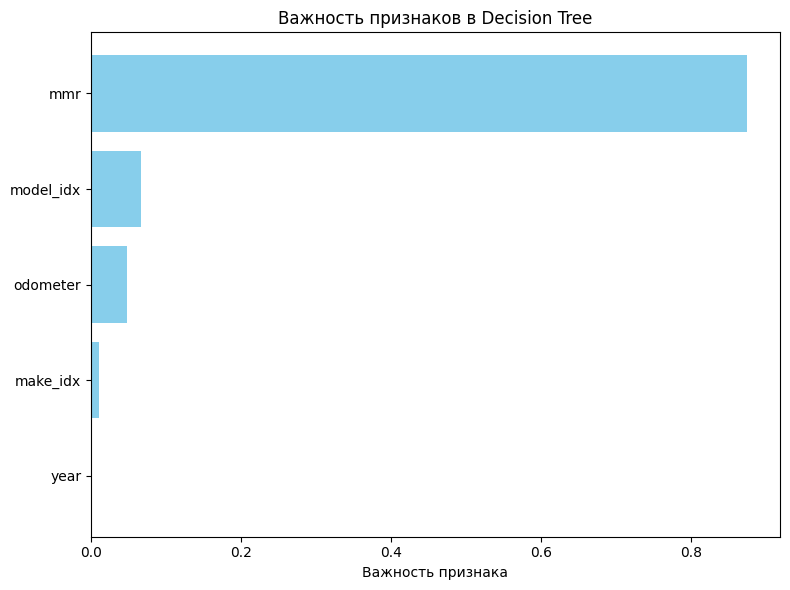

Важность признаков:
year: 0.0000
odometer: 0.0478
mmr: 0.8747
make_idx: 0.0110
model_idx: 0.0666


In [21]:
# ЯЧЕЙКА 6.5 — ГРАФИК ВАЖНОСТИ ПРИЗНАКОВ (очень красиво для отчёта!)

import matplotlib.pyplot as plt
import pandas as pd

# Получаем важность признаков из обученного дерева
importances = model.featureImportances.toArray()

# Названия признаков в том же порядке, как мы их подавали
feature_names = ["year", "odometer", "mmr", "make_idx", "model_idx"]

# Создаём датафрейм
imp_df = pd.DataFrame({
    "Признак": feature_names,
    "Важность": importances
}).sort_values("Важность", ascending=False)

# Строим график
plt.figure(figsize=(8,6))
plt.barh(imp_df["Признак"], imp_df["Важность"], color="skyblue")
plt.xlabel("Важность признака")
plt.title("Важность признаков в Decision Tree")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Также выведем числовые значения
print("Важность признаков:")
for i, name in enumerate(feature_names):
    print(f"{name}: {importances[i]:.4f}")

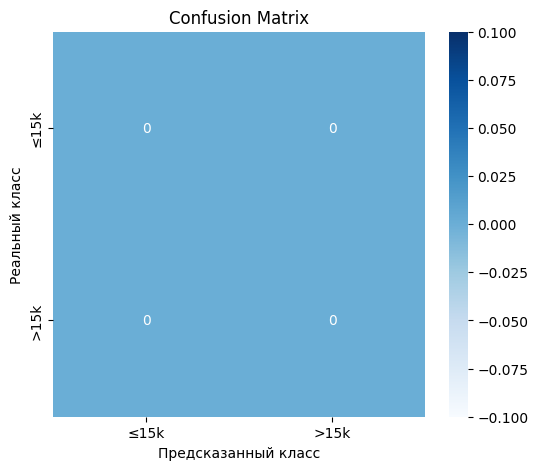

In [22]:
# ЯЧЕЙКА 7 — Красивая матрица ошибок
import matplotlib.pyplot as plt
import seaborn as sns

cm = predictions.crosstab("expensive", "prediction").toPandas()
cm = cm.sort_values("expensive_prediction")

matrix = []
for i in range(len(cm)):
    row = [0, 0]
    if "0" in cm.columns: row[0] = cm.iloc[i]["0"] if pd.notna(cm.iloc[i]["0"]) else 0
    if "1" in cm.columns: row[1] = cm.iloc[i]["1"] if pd.notna(cm.iloc[i]["1"]) else 0
    matrix.append(row)

plt.figure(figsize=(6,5))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["≤15k", ">15k"],
            yticklabels=["≤15k", ">15k"])
plt.xlabel("Предсказанный класс")
plt.ylabel("Реальный класс")
plt.title("Confusion Matrix")
plt.show()